# CelebA EfficientNet B3

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b3

from sklearn.metrics import classification_report, accuracy_score

# created library
import dataaugmentation
import mydata
from skindetection import SkinExtraction
from skincolors import IndividualTypologyAngle
from performance import PerformanceMeasure, PerformanceEstimation


from mymodels import TransDataset, EfficientB3Model
import training

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
2024-08-12 16:15:49.417067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 16:15:49.441411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 16:15:50.060537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# to reproduce

seed = 42
random.seed(seed) #　ほかのモジュールで使われているかも
np.random.seed(seed) # ほかのモジュールで使われているかも
torch.manual_seed(seed) # Pytorchの中のシード
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # GPUの計算過程の変化をさせない

## Load Dataset

In [3]:
db = "CelebA"
root = f"../../dataset/AAAI 2025/{db}/"
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test_with_skincolor.csv")

# Data Trainning

In [4]:
ycol="labels"
batch_size = 8
train_loader, valid_loader, test_loader = training.create_dataloaders(df_train, df_valid, df_test, ycol, batch_size)

H*W:  (218, 178)


Validation Accuracy: 0.6245 | Loss: 0.8981 | F1: 0.5831
Validation Accuracy: 0.7213 | Loss: 0.6875 | F1: 0.6907
Validation Accuracy: 0.7848 | Loss: 0.7498 | F1: 0.7556
Validation Accuracy: 0.8021 | Loss: 0.6356 | F1: 0.7725
Validation Accuracy: 0.8303 | Loss: 0.4101 | F1: 0.8141
Validation Accuracy: 0.8391 | Loss: 0.4123 | F1: 0.8295
Validation Accuracy: 0.8430 | Loss: 0.3591 | F1: 0.8285
Validation Accuracy: 0.8540 | Loss: 0.3437 | F1: 0.8493
Validation Accuracy: 0.8619 | Loss: 0.3959 | F1: 0.8580
Validation Accuracy: 0.8570 | Loss: 0.5977 | F1: 0.8459
Validation Accuracy: 0.8743 | Loss: 0.3682 | F1: 0.8721
Validation Accuracy: 0.8625 | Loss: 1.0603 | F1: 0.8539
Validation Accuracy: 0.8670 | Loss: 0.3124 | F1: 0.8554
Validation Accuracy: 0.8807 | Loss: 0.4784 | F1: 0.8801
Validation Accuracy: 0.8746 | Loss: 1.6564 | F1: 0.8670
Validation Accuracy: 0.8783 | Loss: 0.3112 | F1: 0.8760
Validation Accuracy: 0.8780 | Loss: 0.2805 | F1: 0.8695
Validation Accuracy: 0.8801 | Loss: 0.2744 | F1:

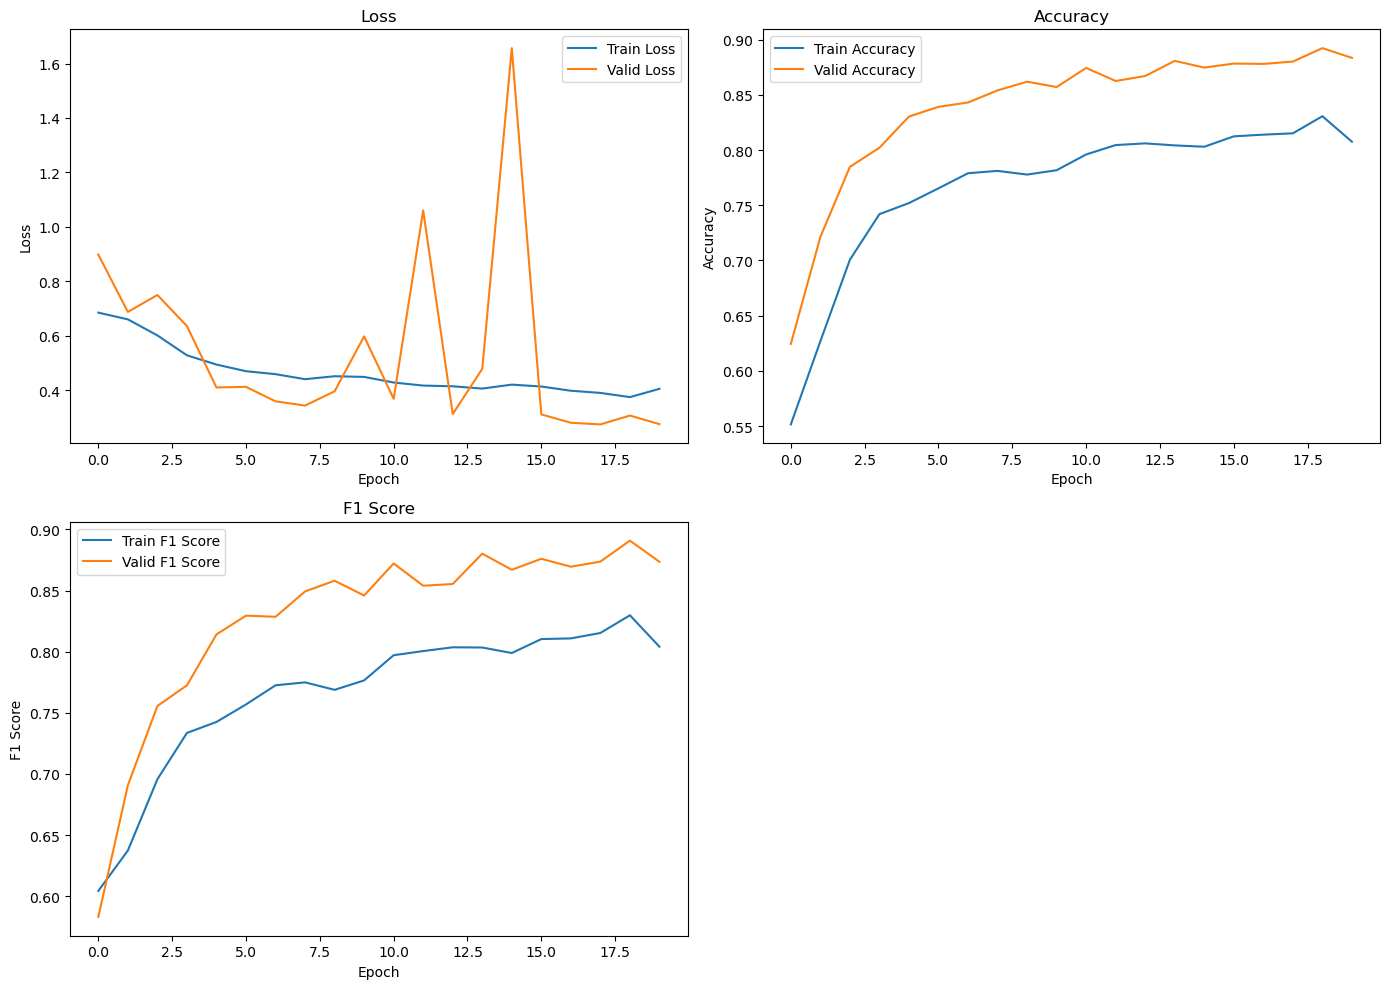

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_directory = f"{root}/model/efficientnet/"
model = EfficientB3Model().to(device) # model -> GPU

# Train the model
num_epochs = 20
lr = 0.00001
best_val_file = training.train_model(model, train_loader, valid_loader, model_save_directory, num_epochs=num_epochs, lr=lr)

# Evaluation

In [6]:
model = EfficientB3Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
with torch.no_grad():
    test_predictions = []
    test_outputs = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
        outputs = model(inputs)
        # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
        test_outputs.append(outputs)
        test_predictions.extend(1 if x >= 0 else 0 for x in outputs) # Appendは１つ、extendは複数

df_test["predictions"] = test_predictions

In [7]:
training.test_classification_report(df_test)
df_test.to_csv(f"../../dataset/AAAI 2025/{db}/evaluation/df_test_ef3.csv", index=False)

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2107
           1       0.93      0.84      0.88      2169

    accuracy                           0.88      4276
   macro avg       0.89      0.89      0.88      4276
weighted avg       0.89      0.88      0.88      4276

Skin tone 2: Accuracy 0.8719257540603248
Skin tone 1: Accuracy 0.8981612446958982


## Training with Weights

In [ ]:
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

class CustomBCEWithLogitsLoss(nn.Module):
    def __init__(self):
        super(CustomBCEWithLogitsLoss, self).__init__()

    def forward(self, outputs, targets): # criterion
        bce_loss = F.binary_cross_entropy(outputs, targets)
        penalty = 0.2
        return bce_loss + penalty

def train_model(model, train_loader, valid_loader, num_epochs=25, lr=1e-5):

    train_losses = []
    valid_losses = []
    train_f1s = []
    valid_f1s = []
    train_aucs = []
    valid_aucs = []
    train_accuracies = []
    valid_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    criterion = CustomBCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward() # Partial Derivative
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_f1 = f1_score(all_labels, [1 if x >= 0 else 0 for x in all_preds])
        epoch_auc = roc_auc_score(all_labels, all_preds)
        epoch_acc = accuracy_score(all_labels, [1 if x >= 0 else 0 for x in all_preds])

        train_losses.append(epoch_loss)
        train_f1s.append(epoch_f1)
        train_aucs.append(epoch_auc)
        train_accuracies.append(epoch_acc)

        #print(f'Epoch {epoch}/{num_epochs - 1} | Loss: {epoch_loss:.4f} | F1: {epoch_f1:.4f} | AUC: {epoch_auc:.4f}')
        
        model.eval() # Validation だから。
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_preds.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(valid_loader.dataset)
        val_f1 = f1_score(val_labels, [1 if x >= 0.5 else 0 for x in val_preds])
        val_auc = roc_auc_score(val_labels, val_preds)
        val_acc = accuracy_score(val_labels, [1 if x >= 0.5 else 0 for x in val_preds])

        valid_losses.append(val_loss)
        valid_f1s.append(val_f1)
        valid_aucs.append(val_auc)
        valid_accuracies.append(val_acc)

        print(f'Validation Accuracy: {val_acc:.4f} | Loss: {val_loss:.4f} | F1: {val_f1:.4f} | AUC: {val_auc:.4f}')

        scheduler.step()
        
    epochs = range(num_epochs)
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_f1s, label='Train F1 Score')
    plt.plot(epochs, valid_f1s, label='Valid F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.show()

In [ ]:
train_model(model, train_loader, valid_loader, num_epochs=20, lr=1e-5)